# 使用字符级RNN生成名称

## 概述

在NLP的教程[《使用字符级RNN分类名称》](https://www.mindspore.cn/tutorial/zh-CN/master/middleclass/text/rnn_classification.html)中，我们使用了RNN将名称与对应语言进行分类。这次，我们将通过反向操作来生成不同语言的名称。本教程我们仍通过编写由一些线性层构建出的的小型RNN来实现目标。此次与之前最大的区别在于，我们不是在输入名字中的所有字母后预测类别，而是输入一个类别，然后一次输出一个字母。这种反复预测字符以形成语言（这也可以用单词或其他高阶结构来完成）的方法通常称为“语言模型”。

## 准备环节

### 配置环境

本教程我们在Ascend环境下，使用PyNative模式运行实验。

In [1]:
from mindspore import context
context.set_context(mode=context.PYNATIVE_MODE, device_target="Ascend")

### 准备数据

下载[数据](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/middleclass/data.zip)，并将其提取到当前目录。

有关此过程的更多详细信息，请参见[《使用字符级RNN分类名称》](https://www.mindspore.cn/tutorial/zh-CN/master/middleclass/text/rnn_classification.html)。 简而言之，数据集由纯文本文件`data/names/[Language].txt`构成，每行都有一个名称。我们将行拆分成一个数组，将Unicode转换为ASCII，最后得到一个字典`{language: [names ...]}`。


在Jupyter Notebook中执行如下命令下载数据集。

In [2]:
!wget -NP ./ https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/middleclass/data.zip
!unzip ./data.zip

## 数据处理

In [3]:
import os
import glob
import string
import unicodedata
from io import open

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

def findFiles(path): return glob.glob(path)

# 将Unicode字符串转换为纯ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 读取文件并切分语句
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 建立类别语句的字典同时保存类别的列表
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data set to the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Japanese', 'Chinese', 'Polish', 'Scottish', 'Vietnamese', 'Czech', 'Portuguese', 'Dutch', 'Greek', 'French', 'Arabic', 'Russian', 'Spanish', 'Korean', 'English', 'Italian', 'German', 'Irish']
O'Neal


## 创建网络

该网络基于[《使用字符级RNN分类名称》](https://www.mindspore.cn/tutorial/zh-CN/master/middleclass/text/rnn_classification.html)这篇教程中的RNN网络进行了扩展，附加了一个与其他向量连接在一起的新参数向量。该变量与字母输入采用一样的one-hot编码。

与上一个网络结构略有不同，为了有更好的效果，在`output combined`层之后我们又添加了一个线性层`o2o`。与此同时也新添加一个`dropout`层，根据[论文](https://arxiv.org/abs/1207.0580)以一定的概率（此处为0.1）将输入的部分随机归零。这一步骤通常用于模糊输入来防止过拟合。这里我们在网络末端利用这一特性来故意添加意外情况，以及样本的多样性。

![](images/run2.png)

In [4]:
import mindspore.nn as nn
import mindspore.ops as ops

class RNN(nn.Cell):
    """定义RNN网络"""
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Dense(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Dense(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Dense(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(axis=1)

    def construct(self, category, input, hidden):
        # 构建RNN网络结构
        op = ops.Concat(axis=1)
        input_combined = op((category, input, hidden))
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = op((hidden, output))
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Tensor(np.zeros((1, self.hidden_size)),mstype.float32)

## 训练

### 准备训练

首先，定义一个能获取随机对`(category，line)`的辅助函数：

In [5]:
import random

# 从列表中随机生成随即对
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 获取随机类并获取该类的随机行
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

对于训练集中的每个名称，该网络的输入为：`(category, current letter, hidden state)`，输出为：`(next letter, next hidden state)`。因此对于每个训练集，我们都需要`categoryTensor`（代表种类的one-hot向量），用于输入的`inputTensor`（由首字母到尾字母（不包括EOS）组成的one-hot矩阵）和用于输出的`targetTensor`（由第二个字母到尾字母（不包括EOS）组成的向量）。

在每个timestep中，因为我们需要预测当前字母所对应的下一个字母，所以需要拆分连续字母来组成字母对。例如：对于`"ABCD<EOS>"`，我们将创建出`('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'EOS')`字母对。

![](images/pair.png)

我们在训练时会持续将`category`向量传输至网络中，该向量是大小为`<1 x n_categories>`的[one-hot向量](https://en.wikipedia.org/wiki/One-hot)。

In [6]:
# 代表category的one-hot向量
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = Tensor(np.zeros((1, n_categories)),mstype.float32)
    tensor[0,li] = 1.0
    return tensor

# 定义输入为一个由首字母到尾字母（不包括EOS）组成的one-hot矩阵
def inputTensor(line):
    tensor = Tensor(np.zeros((len(line), 1, n_letters)), mstype.float32)
    for li in range(len(line)):
        letter = line[li]
        tensor[li,0,all_letters.find(letter)] = 1.0
    return tensor

# 由第二个字母到尾字母(不包括EOS)组成的向量
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return Tensor(np.array(letter_indexes), mstype.int64)

为了方便训练，我们将使用`randomTrainingExample`函数来获取随机对`(category，line)`，并将其转换为所需格式的`(category, input, target)`向量。

In [7]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### 训练网络

与分类模型依赖最后输出作为结果不同，这里我们在每一步都进行了预测，因此每一步都需要计算损失。

In [8]:
from mindspore import ops
from mindspore.nn.loss import Loss

# 定义Loss计算
class NLLLoss(Loss):
    def __init__(self, reduction='mean'):
        super(NLLLoss, self).__init__(reduction)
        self.one_hot = ops.OneHot()
        self.reduce_sum = ops.ReduceSum()
    def construct(self, logits, label):
        label_one_hot = self.one_hot(label, ops.shape(logits)[-1], ops.ScalarToArray(1.0), ops.ScalarToArray(0.0))
        loss = self.reduce_sum(-1.0 * logits * label_one_hot, (1,))
        return self.get_loss(loss)

In [9]:
criterion = NLLLoss()

In [10]:
from mindspore import nn, ops, Tensor
import numpy as np
from mindspore import dtype as mstype

class WithLossCellRnn(nn.Cell):
    """构建有损失计算的RNN网络"""
    def __init__(self, backbone,loss_fn):
        super(WithLossCellRnn, self).__init__(auto_prefix=True)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, category_tensor, input_line_tensor, hidden, target_line_tensor):
        loss = 0
        for i in range(input_line_tensor.shape[0]):
            output, hidden = self._backbone(category_tensor, input_line_tensor[i], hidden)
            l = self._loss_fn(output, target_line_tensor[i])
            loss += l
        return loss

In [11]:
rnn_cf = RNN(n_letters, 128, n_letters)

# 创建优化器和损失网络实例
optimizer = nn.Momentum(filter(lambda x:x.requires_grad,rnn_cf.get_parameters()),0.0001,0.9)
net_with_criterion = WithLossCellRnn(rnn_cf, criterion)
net = nn.TrainOneStepCell(net_with_criterion, optimizer)
net.set_train()
# 定义训练方法
def train(category_tensor,input_line_tensor, target_line_tensor):
    new_shape = list(target_line_tensor.shape)
    new_shape.append(1)
    target_line_tensor = target_line_tensor.reshape(new_shape)
    hidden = rnn_cf.initHidden()
    loss = net(category_tensor, input_line_tensor, hidden,target_line_tensor)
    for i in range(input_line_tensor.shape[0]):
        output, hidden = rnn_cf(category_tensor, input_line_tensor[i], hidden)
    return  output, loss / input_line_tensor.shape[0]

为了跟踪训练需要多长时间，这里添加了一个`timeSince`函数，方便我们持续看到训练的整个过程：

In [12]:
import time
import math
# 定义可读时间回调字符串
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

在训练过程中，每经过`print_every`个样本打印当前时间和损失值。同时，在`all_losses`中根据`plot_every`的设定值计算平均损失，以便于后面绘制训练的过程图像。

In [13]:
n_iters = 7500
print_every = 500
plot_every = 100
all_losses = []
# 每经过100次迭代，就重置为0
total_loss = 0 

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f'% (timeSince(start), iter, iter / n_iters * 100, loss.asnumpy())) 
    if iter % plot_every == 0:
        all_losses.append((total_loss / plot_every).asnumpy())
        total_loss = 0

1m 50s (500 6%) 3.6736
2m 55s (1000 13%) 3.7153
4m 4s (1500 20%) 4.1140
5m 12s (2000 26%) 4.0867
6m 16s (2500 33%) 3.5248
7m 21s (3000 40%) 3.9484
8m 26s (3500 46%) 3.5863
9m 30s (4000 53%) 3.8334
10m 34s (4500 60%) 4.1381
11m 38s (5000 66%) 4.1342
12m 43s (5500 73%) 3.1236
13m 48s (6000 80%) 3.8153
15m 0s (6500 86%) 4.0366
16m 3s (7000 93%) 4.0648
17m 9s (7500 100%) 3.6050


使用`matplotlib.pyplot`绘制训练过程中损失函数的图像。

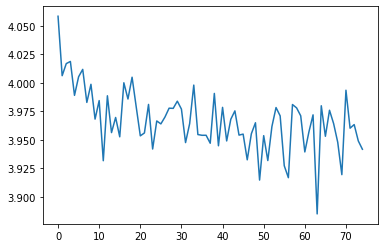

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)

## 验证模型

在训练结束后，对获得的模型进行验证。这里，我们向网络中输入一个字母并推理得出下一个。将这一步的输出字母作为下一步的输入，重复直到EOS标记处。


In [16]:
max_length = 20

# 根据类别与起始字母创建名称
def sample(category, start_letter='A'):
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = rnn_cf.initHidden()
    output_name = start_letter
    for i in range(max_length):
        output, hidden = rnn_cf(category_tensor, input[0], hidden)
        topk = ops.TopK(sorted=True)
        topv, topi = topk(output,1)
        topi = topi[0,0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = inputTensor(letter)

    return output_name

# 遍历提供的字母，得到输出名称
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rrlk
Usnaolena
Srkeaaainiknnuoo
Gtranarssir
Eauasacgliratgiukra
Rilasakaaagitnhrgoaus
Senah
Po
Atainalliganiiaiohua
Cmar
He
Iaaaere
